In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import glob
import tqdm
#FILES=glob.glob("../../datasets/med_MNIST/AbdomenCT/*jpeg")
FILES1=glob.glob("../../datasets/med_MNIST/AbdomenCT/*jpeg")
FILES2=glob.glob("../../datasets/med_MNIST/BreastMRI/*jpeg")
#FILES

/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [15]:
import PIL
import numpy as np
from PIL import Image
from numpy import asarray
# Open the image form working directory
num_train_samples=1500
from tqdm import tqdm

def getData(num_train_samples=1000,FILEPATHS=['../../datasets/med_MNIST/AbdomenCT/*jpeg',
                       '../../datasets/med_MNIST/BreastMRI/*jpeg']):
    FILES={}
    count=0
    for i in FILEPATHS:
        FILES[count]=glob.glob(i)
        count=count+1
        
    NUM_CLASSES=len(FILEPATHS)
    ar_tr = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_tr=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    ar_ts = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_ts=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    count=0
    for f in tqdm(FILES[0]):
        #print('XX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count,:,:,1]=data
            ar_tr[count,:,:,2]=data
            ar_tr[count,:,:,0]=data
            label_tr[count]=0
        if count>=num_train_samples:
            data = asarray(image)
            ar_ts[count-num_train_samples,:,:,1]=data
            ar_ts[count-num_train_samples,:,:,2]=data
            ar_ts[count-num_train_samples,:,:,0]=data
            label_ts[count-num_train_samples]=0
        count=count+1
        if count==num_train_samples*2:
            break


    count=0
    for f in tqdm(FILES[1]):
        #print('XXX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count+num_train_samples,:,:,1]=data
            ar_tr[count+num_train_samples,:,:,2]=data
            ar_tr[count+num_train_samples,:,:,0]=data
            label_tr[count+num_train_samples]=1
        if count>=num_train_samples:
            data = asarray(image)
            #print(count)
            ar_ts[count,:,:,1]=data
            ar_ts[count,:,:,2]=data
            ar_ts[count,:,:,0]=data
            label_ts[count]=1
        count=count+1
        if count==num_train_samples*2:
            break
    
    x_train=ar_tr
    x_test=ar_ts
    y_train=label_tr
    y_test=label_ts
    return (x_train, y_train), (x_test, y_test)

In [16]:
(train_images, train_labels), (test_images, test_labels)=getData(num_train_samples)

 33%|███▎      | 2999/8954 [00:00<00:01, 5581.43it/s]


In [17]:
print(train_images.shape,len(train_labels))
print(test_images.shape,len(test_labels))


(3000, 64, 64, 3) 3000
(3000, 64, 64, 3) 3000


In [18]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

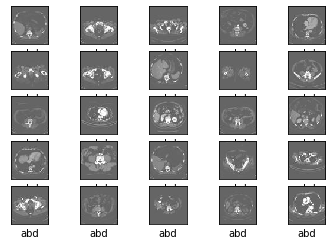

In [22]:
class_names = ['abd','bst']

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])

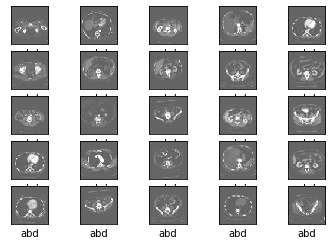

In [23]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [25]:
#model.summary()


In [26]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2,activation=tf.nn.softmax))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=3, 
                    validation_data=(test_images, test_labels))

Train on 3000 samples, validate on 3000 samples
Epoch 1/3
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.3271 - acc: 0.9853 - val_loss: 0.3133 - val_acc: 1.0000
Epoch 2/3
1568/3000 [==============>...............] - ETA: 4s - loss: 0.3133 - acc: 1.0000

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
history.history